In [27]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [28]:
N1, N2, N12, t = np.loadtxt("../data/coincidence_cs137_run2.csv", delimiter=',', unpack=True, skiprows=1)

N1 = unp.uarray(N1, np.sqrt(N1))
N2 = unp.uarray(N2, np.sqrt(N2))
N12 = unp.uarray(N12, np.sqrt(N12))
t = unp.uarray(t, ERROR_TIME)

m1 = N1 / t
m2 = N2 / t
m12 = N12 / t

In [29]:
# params, *_ = np.linalg.lstsq(
#     (unp.nominal_values(m1*m2))[:,np.newaxis],
#     unp.nominal_values(m12)
# )
coefs, cov = np.polyfit(
    unp.nominal_values(m1*m2),
    unp.nominal_values(m12),
    1,
    w=1/unp.std_devs(m12),
    cov=True
)
coefs_err = unp.uarray(coefs, np.sqrt(np.diag(cov)))
fitfunc = np.poly1d(coefs)
twotheta = coefs[0]

test_twotheta = m12 / (m1*m2)
print(f'Unique measures min: {test_twotheta.min()}, max: {test_twotheta.max()}, mean: {test_twotheta.mean()}')
# sigma_twotheta = pass
print(f'Fit: {twotheta}')

Unique measures min: (1.98+/-0.09)e-06, max: (2.37+/-0.12)e-06, mean: (2.110+/-0.018)e-06
Fit: 2.042028935806682e-06


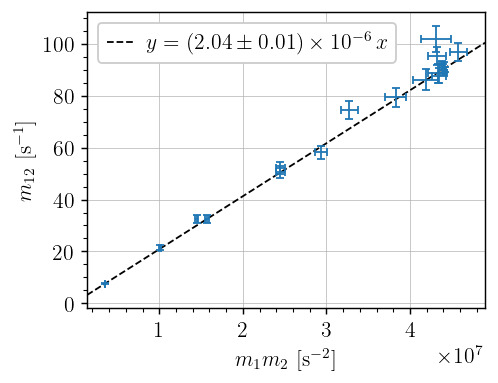

In [30]:
plt.xlabel('$m_1 m_2$ [s$^{-2}$]')
plt.ylabel('$m_{12}$ [s$^{-1}$]')

plt.errorbar(
    unp.nominal_values(m1*m2),
    unp.nominal_values(m12),
    xerr=unp.std_devs(m1*m2), yerr=unp.std_devs(m12), 
    ls='', capsize=2)

old_lims = plt.xlim()
x = np.linspace(*old_lims, 200)
plt.plot(x, fitfunc(x),
         ls='--', c='k',
         label=r'$y = {:.1uepL} \: x$'.format(*coefs_err),
         zorder=1)
plt.xlim(old_lims)
plt.legend()
plt.savefig('../figures/twotheta_cs137.pdf')

In [31]:
with open('../data/2theta_resolution.csv', 'w') as f:
    f.seek(0)
    f.write(str(twotheta))
    f.truncate()